In [16]:
## Import neccessary libraries
import pandas as pd
from pathlib import Path

## Set up path
BASE_PATH = Path.cwd().parent.parent.parent
root_path = BASE_PATH / "data"
MODEL_PATH = BASE_PATH / "models"

In [2]:
df = pd.read_parquet(root_path / "final_data.parquet")
df.shape

(474965, 16)

# Random Forest Model

In [3]:
## Import neccessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

In [4]:
# Split the data into features (X) and target (y)
X = df.drop("CVDSTRK3", axis=1)
y = df["CVDSTRK3"]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
# Oversample and plot imbalanced dataset with SMOTE !!!!! added this after I messaged Kevin on Slack to see if it would solve the problem
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

counter = Counter(y_train)
print(counter)

Counter({1.0: 336027, 2.0: 336027})


In [6]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [7]:
y_pred = rf.predict(X_test)

In [8]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9259840198751487


In [9]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.68      0.67      0.68     10969
         2.0       0.96      0.96      0.96     84024

    accuracy                           0.93     94993
   macro avg       0.82      0.81      0.82     94993
weighted avg       0.93      0.93      0.93     94993



In [11]:
param_dist = {"n_estimators": randint(50, 500), "max_depth": randint(1, 20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=5, cv=5, n_jobs=-1
)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x16e53fa60>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x103a7b430>})

In [12]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print("Best hyperparameters:", rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 235}


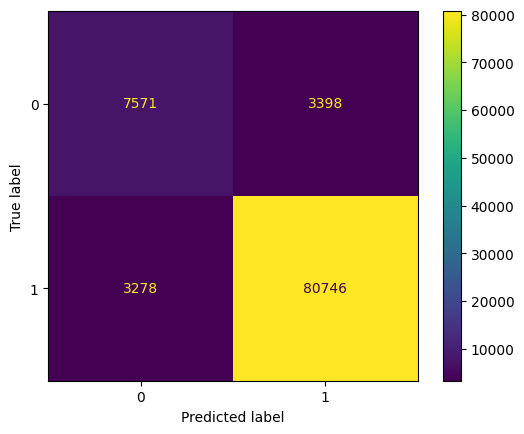

In [13]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

## The confusion matrix is upside down LOL 0 -> Stroke Positive 1-> Stroke Negative
## Using SMOTE seems to have brought up the number of false positives which is expected (slay) this is okay in our case because we are providing a preventative diagnostic

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.70      0.69      0.69     10969
         2.0       0.96      0.96      0.96     84024

    accuracy                           0.93     94993
   macro avg       0.83      0.83      0.83     94993
weighted avg       0.93      0.93      0.93     94993



In [17]:
# loading dependecy
import joblib

# saving our model
joblib.dump(best_rf, MODEL_PATH / "best_rf_stroke_merged.model")

['/Users/kevin/repo/students/lsi-stroke/models/best_rf_stroke_merged']